<a href="https://colab.research.google.com/github/0x0is1/eigenface-mesh/blob/main/eigenface-mesh-poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This work is based on this paper https://koreascience.kr/article/JAKO201336447761947.pdf

In [ ]:
!pip install pycryptodome

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!ls /root/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download olgabelitskaya/yale-face-database

 85% 10.0M/11.8M [00:01<00:00, 16.0MB/s]
100% 11.8M/11.8M [00:01<00:00, 10.3MB/s]


In [ ]:
!mkdir yale-face-database
!unzip ./yale-face-database.zip -d ./yale-face-database/

mkdir: cannot create directory ‘yale-face-database’: File exists
Archive:  ./yale-face-database.zip
  inflating: ./yale-face-database/Readme.txt  
  inflating: ./yale-face-database/data/Readme.txt  
  inflating: ./yale-face-database/data/subject01.centerlight  
  inflating: ./yale-face-database/data/subject01.glasses  
  inflating: ./yale-face-database/data/subject01.happy  
  inflating: ./yale-face-database/data/subject01.leftlight  
  inflating: ./yale-face-database/data/subject01.noglasses  
  inflating: ./yale-face-database/data/subject01.normal  
  inflating: ./yale-face-database/data/subject01.rightlight  
  inflating: ./yale-face-database/data/subject01.sad  
  inflating: ./yale-face-database/data/subject01.sleepy  
  inflating: ./yale-face-database/data/subject01.surprised  
  inflating: ./yale-face-database/data/subject01.wink  
  inflating: ./yale-face-database/data/subject02.centerlight  
  inflating: ./yale-face-database/data/subject02.glasses  
  inflating: ./yale-face-dat

In [ ]:
!rm ./yale-face-database/data/Readme.txt

In [ ]:
!pip install mediapipe opencv-python-headless

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import os
from matplotlib import image as mpimg
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def load_yale_face_dataset(directory, test_ratio=0.2):
    X_train_features = []
    X_test_features = []
    y_train_labels = []
    y_test_labels = []
    subject_names = {}
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files.sort()
    num_images = len(image_files)
    num_test_images = int(test_ratio * num_images)
    for i, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        img = mpimg.imread(img_path)
        if img is not None:
            resized_img = np.array(Image.fromarray(img).resize((100, 100)))
            flattened_img = resized_img.flatten()
            subject_id = int(img_name.split('.')[0][-2:])
            subject_name = img_name.split('.')[0].split('_')[0]
            subject_names[subject_id] = subject_name
            if i < num_test_images:
                X_test_features.append(flattened_img)
                y_test_labels.append(subject_id)
            else:
                X_train_features.append(flattened_img)
                y_train_labels.append(subject_id)
    return (
        np.array(X_train_features), np.array(X_test_features),
        np.array(y_train_labels), np.array(y_test_labels),
        subject_names
    )


In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from PIL import Image

def extract_mediapipe_face(image_path):
    # Load the image using OpenCV
    pil_image = Image.open(image_path)
    image = np.array(pil_image)

    # Convert the image to RGB if it's grayscale
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Initialize MediaPipe Face Detection
    mp_face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)
    # Convert the image to RGB (MediaPipe requires RGB images)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process the image with MediaPipe Face Detection
    results = mp_face_detection.process(image_rgb)

    # Check if any faces were detected
    if results.detections:
        # Assuming there's only one face detected, get the bounding box coordinates
        bbox = results.detections[0].location_data.relative_bounding_box
        h, w, _ = image.shape
        xmin = int(bbox.xmin * w)
        ymin = int(bbox.ymin * h)
        xmax = int((bbox.xmin + bbox.width) * w)
        ymax = int((bbox.ymin + bbox.height) * h)

        # Crop the face region from the image
        face_image = image[ymin:ymax, xmin:xmax]

        # Resize the face image to a fixed size (e.g., 100x100)
        resized_face = cv2.resize(face_image, (100, 100))

        # Convert the resized face image to grayscale
        gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)

        return gray_face

    else:
        print("No face detected in the image.")
        return None

def load_mediapipe_face_dataset(directory, test_ratio=0.2):
    X_train_features = []
    X_test_features = []
    y_train_labels = []
    y_test_labels = []
    subject_names = {}
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files.sort()
    num_images = len(image_files)
    num_test_images = int(test_ratio * num_images)

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        # Extract face using MediaPipe
        face_image = extract_mediapipe_face(img_path)

        if face_image is not None:
            flattened_img = face_image.flatten()
            subject_id = int(img_name.split('.')[0][-2:])
            subject_name = img_name.split('.')[0].split('_')[0]
            subject_names[subject_id] = subject_name
            if i < num_test_images:
                X_test_features.append(flattened_img)
                y_test_labels.append(subject_id)
            else:
                X_train_features.append(flattened_img)
                y_train_labels.append(subject_id)

    return (
        np.array(X_train_features), np.array(X_test_features),
        np.array(y_train_labels), np.array(y_test_labels),
        subject_names
    )

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from PIL import Image

def extract_mediapipe_face_landmarks(image_path):
    pil_image = Image.open(image_path)
    image = np.array(pil_image)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    mp_face_mesh = mp.solutions.face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = mp_face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0]

        landmark_points = []
        for landmark in face_landmarks.landmark:
            x = landmark.x * image.shape[1]
            y = landmark.y * image.shape[0]
            landmark_points.append([x, y])

        return np.array(landmark_points)

    else:
        print("No face detected in the image.")
        return None

def load_mediapipe_face_landmarks_dataset(directory, test_ratio=0.2):
    X_train_landmarks = []
    X_test_landmarks = []
    y_train_labels = []
    y_test_labels = []
    subject_names = {}
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    image_files.sort()
    num_images = len(image_files)
    num_test_images = int(test_ratio * num_images)

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(directory, img_name)
        landmarks = extract_mediapipe_face_landmarks(img_path)

        if landmarks is not None:
            flattened_landmarks = landmarks.flatten()
            subject_id = int(img_name.split('.')[0][-2:])
            subject_name = img_name.split('.')[0].split('_')[0]
            subject_names[subject_id] = subject_name
            if i < num_test_images:
                X_test_landmarks.append(flattened_landmarks)
                y_test_labels.append(subject_id)
            else:
                X_train_landmarks.append(flattened_landmarks)
                y_train_labels.append(subject_id)

    return (
        np.array(X_train_landmarks), np.array(X_test_landmarks),
        np.array(y_train_labels), np.array(y_test_labels),
        subject_names
    )

In [ ]:
def compute_eigenfaces(X_train, n_components=10):
    if not 0 <= n_components <= min(X_train.shape):
        raise ValueError(f"Invalid value for n_components. It must be between 0 and {min(X_train.shape)}.")

    pca = PCA(n_components=n_components, svd_solver='full')
    pca.fit(X_train)
    eigenfaces = pca.components_
    return eigenfaces, pca.mean_

In [ ]:
def project_faces(X, eigenfaces, pca_mean):
    centered_data = X - pca_mean
    eigen_space = np.transpose(eigenfaces)
    return np.dot(centered_data, eigen_space)

In [ ]:
def encrypt_face_templates(face_templates, user_key):
    cipher = AES.new(user_key, AES.MODE_ECB)
    encrypted_templates = [cipher.encrypt(template.tobytes()) for template in face_templates]
    return encrypted_templates

def decrypt_and_match(test_face_template, encrypted_templates, user_key, mode=0):
    cipher = AES.new(user_key, AES.MODE_ECB)
    decrypted_templates = [np.frombuffer(cipher.decrypt(encrypted_template), dtype=np.float64) for encrypted_template in encrypted_templates]

    if mode==1:
      fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
      for i, ax in enumerate(axes.flat):
          ax.imshow(decrypted_templates[i].reshape(12, 11), cmap='gray')
          ax.set_title(f'Decrypted Projection {i+1}')
      plt.tight_layout()
      plt.show()

    distances = [np.linalg.norm(test_face_template - template) for template in decrypted_templates]
    min_distance = min(distances)
    return np.argmin(distances), min_distance


In [ ]:
dataset_directory = "./yale-face-database/data"
# X_train_features, X_test_features, y_train_labels, y_test_labels, subject_names = load_yale_face_dataset(dataset_directory)
# X_train_features, X_test_features, y_train_labels, y_test_labels, subject_names = load_mediapipe_face_dataset(dataset_directory)
X_train_features, X_test_features, y_train_labels, y_test_labels, subject_names = load_mediapipe_face_landmarks_dataset(dataset_directory)


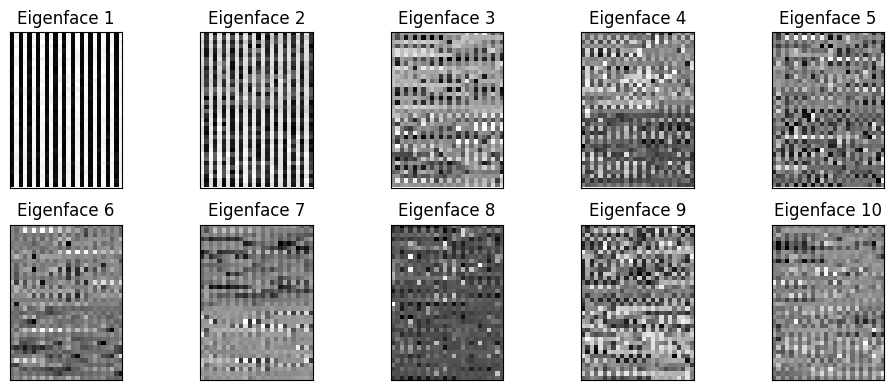

In [ ]:
try:
    if len(X_train_features) > 0 and len(X_test_features) > 0:
        eigenfaces, pca_mean = compute_eigenfaces(X_train_features, n_components=132)
        fig, axes = plt.subplots(2, 5, figsize=(10, 4), subplot_kw={'xticks': [], 'yticks': []})
        for i, ax in enumerate(axes.flat):
            # ax.imshow(eigenfaces[i].reshape(100, 100), cmap='gray')
            ax.imshow(eigenfaces[i].reshape(36, 26), cmap='gray')
            ax.set_title(f'Eigenface {i+1}')

        plt.tight_layout()
        plt.show()
except Exception as e:
    print(e)


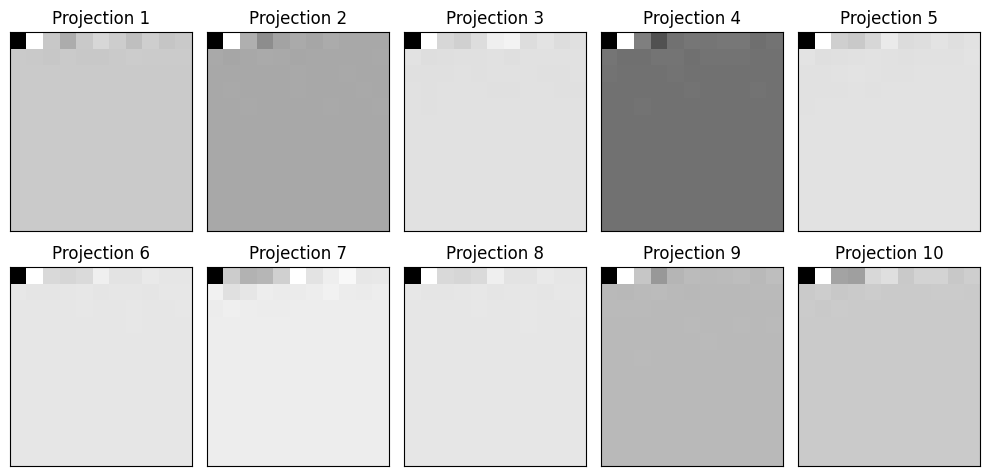

In [ ]:
projected_train_faces = project_faces(X_train_features, eigenfaces, pca_mean)
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(projected_train_faces[i].reshape(12, 11), cmap='gray')
    ax.set_title(f'Projection {i+1}')

plt.tight_layout()
plt.show()

In [ ]:
user_key = get_random_bytes(16)
encrypted_train_templates = encrypt_face_templates(projected_train_faces, user_key)
for i, j in enumerate(encrypted_train_templates[:11]):
  print(f'AES encrypted face template {i}: {j[:20]}...')

AES encrypted face template 0: b'\xa4\xea\x8ar$\xe5\x95\xb9>b,\xc7\xa8Q\x904\x1b\x8c>\x87'...
AES encrypted face template 1: b'\xff\x17\x12\xe1|\x03|D\x19\x1aO\x04\xe6\xf2\xd6\x95\x90-\x87\xc6'...
AES encrypted face template 2: b'IO\xd3\x80\xac*\xb2\xedf\x14O*\xbb(hR\t\xb1\x18\xf6'...
AES encrypted face template 3: b'\xbe\x108\xb4\xaf\x97\xcb#lMtg\x96\x183\x082\xbd\x9a\xcb'...
AES encrypted face template 4: b'\xd2\xd71p\xe9\x15"\xd2%\xc4D\xf2\xddh\xca\x8eGX\x86a'...
AES encrypted face template 5: b'F]\xf4\x81\x15E\xa7\x9f\x07^tl\x9eP8tPi\xc1n'...
AES encrypted face template 6: b'\xd4\xf2\x85Y\xa7A\xb0\xb5#hfN\xcb\xae\x82\xb7\xff\x97\x1c\xba'...
AES encrypted face template 7: b'F]\xf4\x81\x15E\xa7\x9f\x07^tl\x9eP8tPi\xc1n'...
AES encrypted face template 8: b'\xe2w^a\x0c\x8d\x15\xa4\xc1\x8d\xbb5\\\r\x1d\xbf\xe9U\x94\xde'...
AES encrypted face template 9: b'Jro\xfb\xf5\xd5\xcaQ1\xc5\xb3\x19\x8d\xe8~\xe8@\x13oo'...
AES encrypted face template 10: b'\xad\xad\xdd\xbe`\x02\x85\xde\xf6@\x8e\xc

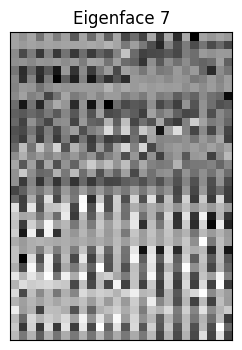

In [ ]:
# Test feature 1 projection
fig, ax = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(X_test_features[0].reshape(36, 26), cmap='gray')
# ax.imshow(X_test_features[0].reshape(100, 100), cmap='gray')
ax.set_title('Eigenface 7')
plt.show()

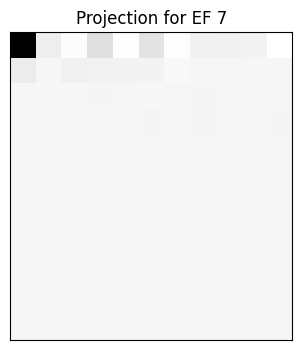

In [ ]:
# Projection of test feature 1
projected_test_face = np.dot(X_test_features[0] - pca_mean, eigenfaces.T)
fig, ax = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(projected_test_face.reshape(12, 11), cmap='gray')
ax.set_title('Projection for EF 7')
plt.show()

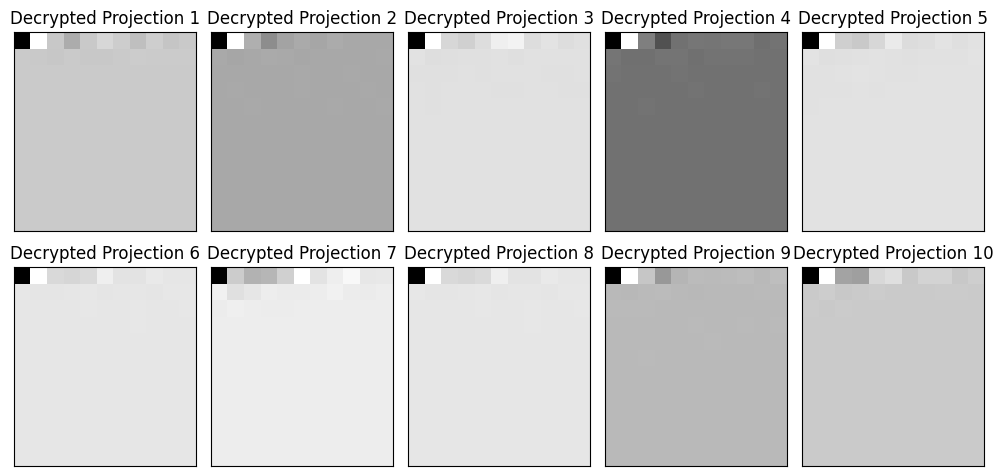

Subject: subject01, min-threshold: 99.82958524068763


In [ ]:
test_features = X_test_features[0]

projected_test_face = np.dot(test_features - pca_mean, eigenfaces.T)

match_result, threshold = decrypt_and_match(projected_test_face, encrypted_train_templates, user_key, 1)
matched_label = subject_names[int(match_result/11)+1]
print(f"Subject: {matched_label}, min-threshold: {threshold}")

In [ ]:
ot = 0
for test_features in X_test_features:
    projected_test_face = np.dot(test_features - pca_mean, eigenfaces.T)
    match_result, threshold = decrypt_and_match(projected_test_face, encrypted_train_templates, user_key)
    matched_label = subject_names[int(match_result/11)+1]
    ot += threshold
    print(f"Subject: {matched_label}, min-threshold: {threshold}")
print(f"Average Threshold : {ot/len(X_test_features)}")

Subject: subject01, min-threshold: 99.82958524068763
Subject: subject06, min-threshold: 100.23543256658874
Subject: subject06, min-threshold: 126.22056833225749
Subject: subject01, min-threshold: 68.37975942358503
Subject: subject09, min-threshold: 142.52156495845594
Subject: subject01, min-threshold: 109.80430681796616
Subject: subject01, min-threshold: 44.92924629966843
Subject: subject07, min-threshold: 62.92397430504848
Subject: subject07, min-threshold: 64.18925818616319
Subject: subject01, min-threshold: 127.01204658318113
Subject: subject06, min-threshold: 96.34794108290032
Subject: subject09, min-threshold: 229.96166245396836
Subject: subject01, min-threshold: 80.95682051776039
Subject: subject01, min-threshold: 131.02624703766395
Subject: subject09, min-threshold: 168.184888150373
Subject: subject09, min-threshold: 128.8718319962452
Subject: subject09, min-threshold: 128.8718319962452
Subject: subject09, min-threshold: 188.07254234789352
Subject: subject01, min-threshold: 113.